In [33]:
import pandas, numpy, os
import geopandas as gpd


def recursive_build(curr_tezgnr, subtree_data, dict_children, dict_parent):
    lst_children = []
    while len(subtree_data) > 0:
        child_idx = (subtree_data.H2 - subtree_data.H1).argmax()
        child_tezgnr = subtree_data.iloc[child_idx].name
        lst_children.append(child_tezgnr)
        dict_parent[child_tezgnr] = curr_tezgnr

        child_h1 = subtree_data.iloc[child_idx].H1
        child_h2 = subtree_data.iloc[child_idx].H2
        child_data = subtree_data.loc[(subtree_data.H1 >= child_h1)
                                      & (subtree_data.H2 < child_h2)]
        recursive_build(child_tezgnr, child_data, dict_children, dict_parent)
        subtree_data = subtree_data.drop(child_data.index).drop(child_tezgnr)
    dict_children[curr_tezgnr] = lst_children


def build_parent_children_dict(data):
    dict_c = {}
    dict_p = {}
    recursive_build(-1, data, dict_c, dict_p)
    parents = pandas.DataFrame.from_dict(dict_p, orient="index")[0]
    return parents, dict_c


def expand_generations(parents):
    lst_gen =[parents.reset_index().rename(columns={"index": 0, 0: 1}).set_index(parents.index)]
    i = 2
    while (parents > -1).any():
        parents = pandas.Series(lst_gen[0][1][parents].values, index=parents.index, name=i)
        i += 1
        lst_gen.append(parents)
    return pandas.concat(lst_gen, axis=1)


def find_neighbors(flow_integrator, max_dist=20000):
    from scipy.spatial import KDTree

    c_xy = numpy.hstack(flow_integrator._centroids.apply(lambda _x: _x.xy).values).transpose()
    tree = KDTree(c_xy)

    pairs = numpy.vstack(list(tree.query_pairs(max_dist)))
    A = flow_integrator._geometry.iloc[pairs[:, 0]]
    B = flow_integrator._geometry.iloc[pairs[:, 1]]
    passes = A.reset_index().geometry.combine(B.reset_index().geometry, lambda _a, _b: _a.intersects(_b))
    pair_idx = pandas.DataFrame({"a": A.index[passes], "b": B.index[passes]})
    return pair_idx


class SourceData(object):
    LOC_BASINS = "EZG_Gewaesser.gpkg"
    LOC_OUTFLOW = os.path.join("EZG_Gewaesser.gdb", "a00000032.gdbtable")
    LOC_CITY_NAMES = "a00000050.gdbtable"
    LOC_CITY_LOCATION = "a00000055.gdbtable"
    col_id = "TEILEZGNR"
    col_name = "LANGTEXT"
    col_uuid = "PLZO_OS_UUID"

    def __init__(self, root, root_cities=None):
        self._basins = gpd.read_file(os.path.join(root, SourceData.LOC_BASINS)).set_index(SourceData.col_id)
        self._outflow = gpd.read_file(os.path.join(root, SourceData.LOC_OUTFLOW)).set_index(SourceData.col_id)
        if root_cities is not None:
            self._city_lo1 = gpd.read_file(os.path.join(root_cities, SourceData.LOC_CITY_NAMES)).set_index(SourceData.col_name)
            self._city_lo2 = gpd.read_file(os.path.join(root_cities, SourceData.LOC_CITY_LOCATION)).set_index(SourceData.col_uuid)
        else:
            self._city_lo1 = None
            self._city_lo2 = None


class FlowIntegrator(object):
    def __init__(self, tbl_basins, tbl_flowout):
        self._basins = tbl_basins
        self._flowout = tbl_flowout
        self._centroids = tbl_basins.geometry.apply(lambda _x: _x.centroid)
        self._geometry = tbl_basins.geometry
        self._flowout = tbl_flowout.geometry
        self._flowout = pandas.concat([
            self._flowout,
            self._centroids[self._centroids.index.difference(self._flowout.index)]
        ], axis=0)
        
        print("Building hierarchy based on outflow...")
        parents, children = build_parent_children_dict(self._basins)
        print("Done!")
        parents[-1] = -1
        self._gens = expand_generations(parents)
    
    def integrate_length(self, row, stop_idx=-1, count_first=True):
        lens = []
        if count_first: pt_fr = self._centroids[row.name]
        else: pt_fr = self._flowout[row.name]
        for _idx in row.values:
            if _idx == -1: break
            pt_to = self._flowout[_idx]
            if _idx == stop_idx:
                break
            lens.append(pt_fr.distance(pt_to))
            pt_fr = pt_to
        return numpy.sum(lens), pt_to
    
    def cumulative_length_for_pair(self, idx1, idx2):
        lca_idx = numpy.nonzero(numpy.in1d(self._gens.loc[idx1], self._gens.loc[idx2]))[0][0]
        lca = self._gens.loc[idx1][lca_idx]
        not_ancestor = (lca != idx1) and (lca != idx2)
        a, pt_a = self.integrate_length(self._gens.loc[idx1], lca, count_first=not_ancestor)
        b, pt_b = self.integrate_length(self._gens.loc[idx2], lca, count_first=not_ancestor)
        if lca == -1:
            return a + b + pt_a.distance(pt_b)
        assert pt_a.distance(pt_b) == 0.0
        return a + b


class WatershedSeparation(object):
    def __init__(self, flow_integrator, pair_max_dist=20000):
        self._flow = flow_integrator
        print("Finding neighboring areas...")
        self.pairs = find_neighbors(flow_integrator, max_dist=pair_max_dist)
        print("Done!")
        print("Calculating separation of {0} pairs...".format(len(self.pairs)))
        self._payload = self.calculate_separation(self.pairs)
        print("Done!")
        self.payload = self._payload

    @staticmethod
    def facultative_conversion(obj):
        import shapely
        from shapely import ops
        if isinstance(obj, shapely.MultiLineString):
            return ops.linemerge(obj)
        return obj

    def calculate_separation(self, pairs):
        pair_sep = pairs.apply(lambda _x: self._flow.cumulative_length_for_pair(*_x), axis=1)
        pair_geom = pairs.applymap(lambda _x: self._flow._geometry[_x])
        pair_inters = pair_geom.apply(lambda _x: _x[0].intersection(_x[1]), axis=1)
        pair_inters = pair_inters.apply(self.facultative_conversion)
        pair_sep.name = "separation"
        pair_inters.name = "border"
        return pandas.concat([pairs, pair_sep, pair_inters], axis=1)

    def filter_lower_res(self, str_prop):
        tbl = self.payload
        series = self._flow._basins[str_prop]
        valid = (series[tbl["a"]].values != series[tbl["b"]].values)
        self.payload = tbl.loc[valid]
        return self
    
    def filter_min_val(self, min_val):
        tbl = self.payload
        valid = tbl["separation"] > min_val
        self.payload = tbl.loc[valid]
        return self
    
    def filter_reset(self):
        self.payload = self._payload
        return self



In [140]:
import numpy
import pandas
import shapely

from matplotlib import pyplot as plt
from matplotlib import cm


DEFAULT_COL = {
    "scale": 0.5,
    "slope": 1.0/400.,
    "offset": -0.75,
    "clip": [0.0, 1.0]
}
DEFAULT_LW = {
    "scale": 0.5,
    "slope": 1.0/175,
    "offset": -0.1,
    "clip": [0.1, 3.0]
}

def make_processor(**kwargs):
    def process(val):
        scale = kwargs.get("scale", None)
        clip = kwargs.get("clip", None)
        if scale == "log":
            val = numpy.log10(val)
        elif isinstance(scale, float):
            val = val ** scale
        val = val * kwargs.get("slope", 1.0)
        val = val + kwargs.get("offset", 0.0)
        if clip is not None:
            val = numpy.maximum(numpy.minimum(val, clip[1]), clip[0])
            
        return val
    return process

def _plot_hlp(plt_specs):
    col = plt_specs["color"]
    lw = plt_specs["lw"]
    coords = plt_specs["border"]
    if isinstance(coords, shapely.LineString):
        plt.plot(*coords.xy, color=col, lw=lw)

def apply_filters(watershed, **kwargs):
    watershed.filter_reset()
    if "min_val" in kwargs:
        watershed.filter_min_val(kwargs["min_val"])
    if "lower_res" in kwargs:
        watershed.filter_lower_res(kwargs["lower_res"])

def plot_according_to_specs(watershed, config):
    print("Plotting the data...")
    proc_col = make_processor(**config.get("color", DEFAULT_COL))
    proc_lw = make_processor(**config.get("linewidth", DEFAULT_LW))
    cmap = cm.__dict__[config.get("colormap", "copper")]
    apply_filters(watershed, **config.get("filters", {"min_val": 0}))

    specs = pandas.concat([watershed.payload["separation"].apply(proc_col).apply(cmap),
                           watershed.payload["separation"].apply(proc_lw),
                           watershed.payload["border"]],
                          keys=["color", "lw", "border"], axis=1)
    fig = plt.figure(figsize=config.get("figsize", (12, 8)))
    ax = fig.add_axes([0.01, 0.01, 0.85, 0.98])
    _ = specs.apply(_plot_hlp, axis=1)
    ax.set_frame_on(False); ax.set_xticks([]); ax.set_yticks([])
    plt.axis("equal")

    ax = fig.add_axes([0.9, 0.25, 0.05, 0.5])
    min_val = 100
    max_val = numpy.percentile(watershed.payload["separation"], 99)
    vals = numpy.linspace(min_val, max_val, 100)
    val_centers = 0.5 * (vals[:-1] + vals[1:])
    cols = proc_col(val_centers)
    lw = proc_lw(val_centers)
    vals = vals / 1000

    for a, b, c, l in zip(vals[:-1], vals[1:], cols, lw):
        plt.plot([0, 0], [a, b], color=cm.copper(c), lw=l)
    ax.set_frame_on(False); ax.set_xticks([])
    ax.yaxis.tick_right()
    ax.set_ylabel("Km")
    print("Done!")
    return fig

import sys, json

with open("../swisswatershed/configuration.json", "r") as fid:
    config = json.load(fid)
data = SourceData(config["data"]["root"], config["data"].get("root_cities", None))
flow = FlowIntegrator(data._basins, data._outflow)
watershed = WatershedSeparation(flow)
    

In [112]:
river_data = gpd.read_file("/home/reimann/Documents/data/geo/EZG_Gewaesser.gdb/a00000033.gdbtable")
river_data = river_data.set_index("Gewaessername")

Plotting the data...
Done!


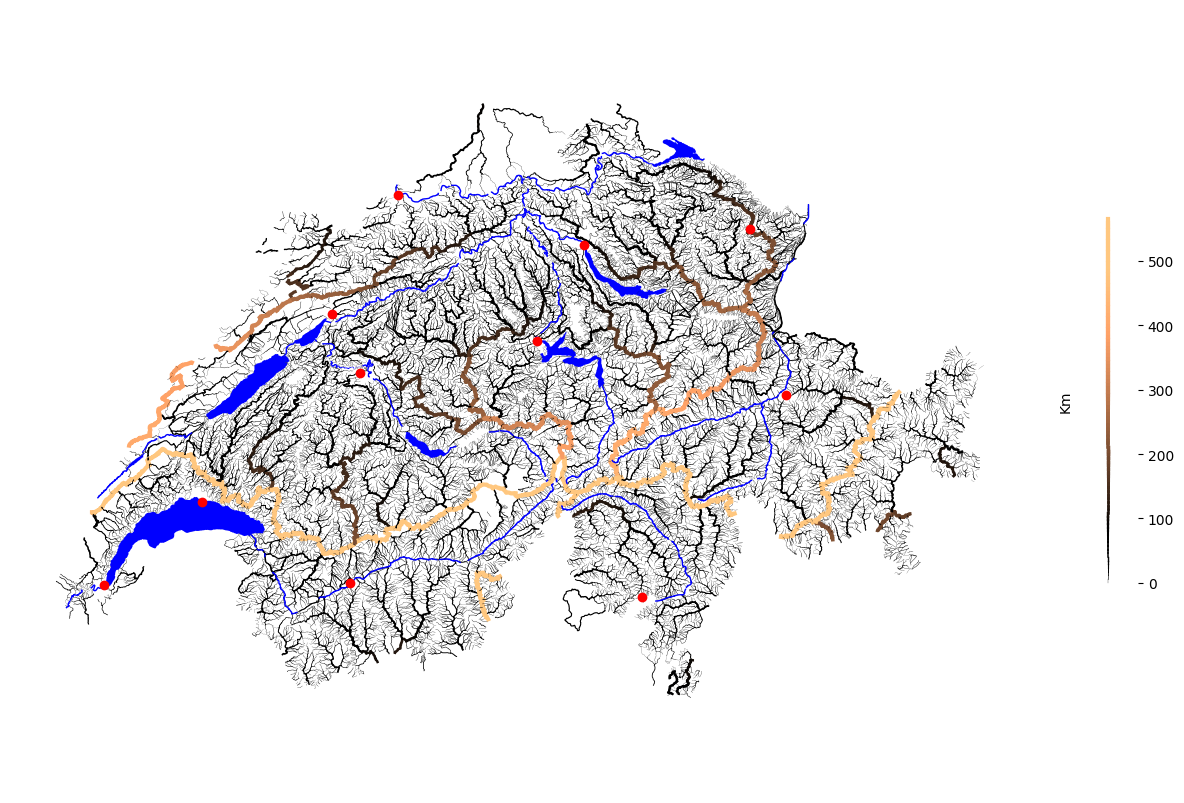

In [153]:
from shapely import ops
from matplotlib.patches import Polygon

config["plotting"]["filters"] = {"min_val": 0}
fig = plot_according_to_specs(watershed, config["plotting"])

lakes = ['Vierwaldstättersee', 'Bodensee Untersee', 'Lac de Joux', 'Le Léman', 'Lac de Neuchâtel',
         'Lac Brenet', 'Bielersee', 'Thunersee', 'Wohlensee', 'Zürichsee']
rivers = ["Rhein", "Ticino", "Rhône", "Aare", "Orbe", "Reuss", "Limmat", 'Canal de la Thielle', 'Hinterrhein']

for river_name in rivers:
    a_river = river_data.loc[river_name]["geometry"].apply(WatershedSeparation.facultative_conversion)
    for ln in a_river.values:
        fig.axes[0].plot(*ln.xy, lw=1.0, color="blue")

is_lake = flow._basins["SEE"].apply(lambda _x: _x.startswith("See"))
for lake_name in lakes:
    geom = ops.unary_union(flow._basins[is_lake & (flow._basins["Gewaessername"] == lake_name)].geometry)
    poly = Polygon(numpy.vstack(geom.exterior.xy).transpose(), facecolor="blue")
    fig.axes[0].add_patch(poly)

if data._city_lo1 is not None:
    for city_name in ["Lausanne", "Zürich", "Bern", "Sion", "Basel", "Genève", "Locarno", "Chur", "St. Gallen","Biel/Bienne", "Luzern"]:
        try:
            city_xy = ops.unary_union(data._city_lo2["geometry"][data._city_lo1["PLZO_OS_UUID"][city_name]]).centroid.xy
            fig.axes[0].plot(*city_xy, marker="o", color="red")
        except:
            print("No city {0} found".format(city_name))

fig.savefig("attempt_v4.svg")

In [116]:
flow._basins.loc[flow._basins["SEE"].apply(lambda _x: _x.startswith("See"))]["Gewaessername"].value_counts().sort_index().index.values

array(['', ' ', '-', 'Aare', 'Aegerisee', 'Albula', 'Amsoldingersee',
       'Arnensee', 'Aubonne', 'Ausgleichsbecken Rivascia', 'Aval Rims',
       'Bacino di Carassino', 'Baldegger See', 'Bavona', 'Bichselsee',
       'Bielersee', 'Binna', 'Bodensee Obersee', 'Bodensee Untersee',
       'Daubensee', 'Derbonne', 'Doubs', "Dranse d'Entremont",
       'Dranse de Bagnes', 'Feldbach', 'Flem', 'Fätschbach', 'Gelgia',
       'Gelmersee', 'Gentalwasser', 'Gigerwaldsee', 'Gougra',
       'Greifensee', 'Grimselsee', 'Gross See', 'Göschener Reuss',
       'Hallwilersee', 'Hinterrhein', 'Hongrin', 'Hüfisee',
       'Hüttwiilersee', 'Iffigsee', 'Igl Lai', 'Inkwiler See', 'Inn',
       'Jona', 'Klingnauer Stausee', 'Klöntaler See', 'Krebsbach',
       'Lac Brenet', "Lac d'Emosson", 'Lac de Biaufond', 'Lac de Bret',
       'Lac de Cleuson', 'Lac de Fionnay', 'Lac de Gruyère',
       'Lac de Joux', 'Lac de Montbovon', 'Lac de Montsalvens',
       'Lac de Moron', 'Lac de Neuchâtel', 'Lac de Seedorf',

In [139]:
avail_rivers = list(river_data.index.to_frame().drop_duplicates().sort_index().index.values)

[_x for _x in avail_rivers if isinstance(_x, str) and _x.startswith("Hinterr")]

['Hinterrhein', 'Hinterriedbach']